#  Прогнозирование количества заказов такси на следующий час

**Заказчик:** компания «Чётенькое такси» 

**Задача:** чтобы привлекать больше водителей в период пиковой нагрузки, необходимо спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
# установка библиотек
!pip install lightgbm
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost as cb
from catboost import CatBoostRegressor
from statsmodels. tsa.stattools import adfuller


In [ ]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data = data.sort_index()
display(data.head(10))
print ('Индексы последовательны? ', data.index.is_monotonic)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Индексы последовательны?  True


In [ ]:
display(data.info())
print('Общее количество значений -', data.shape[0])
print ('Данные за период с', data.index[0], 'по', data.index[-1])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Общее количество значений - 26496
Данные за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00


In [ ]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


**Вывод**
Для исследования предоставлены данные за период с 01/03/2018 по 31/08/2018 (6 месяцев)

Пропуски в данных отсутствуют



## Анализ

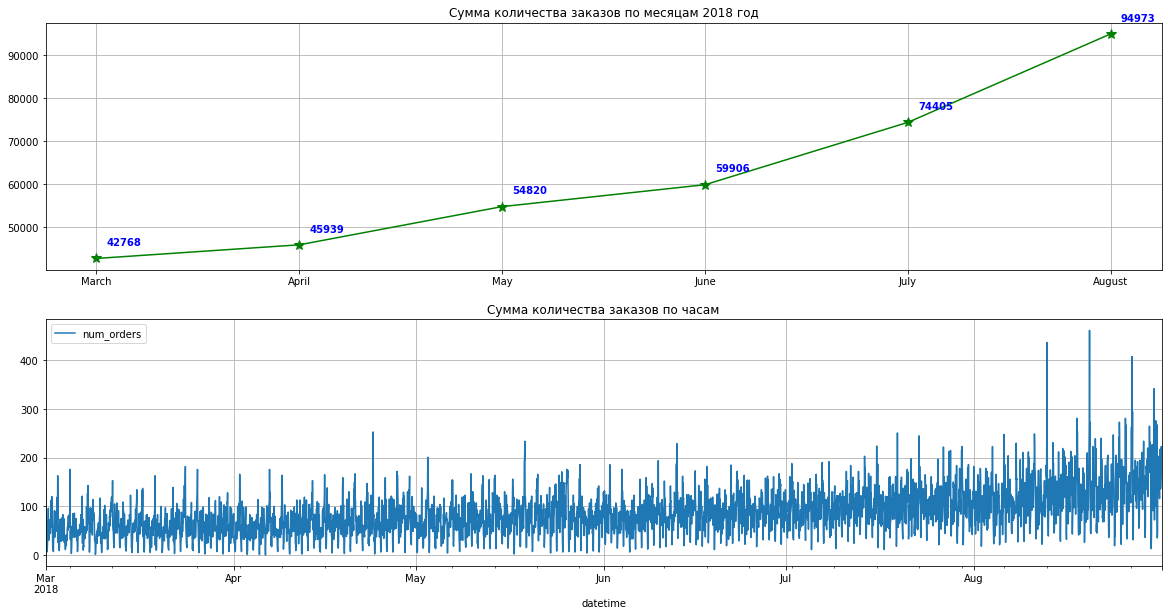

In [ ]:
fig, ax = plt.subplots(2, figsize=(20,10))

data_resampled = data.resample('1M').sum().reset_index()
data_resampled['month'] = data_resampled['datetime'].apply(lambda x: x.strftime('%B')) # название месяца
data_resampled['num_orders'].plot(grid=True, 
                                  title = ('Сумма количества заказов по месяцам 2018 год'), 
                                  marker='*', ms = 10, c='green', ax=ax[0])
for i, v in enumerate(data_resampled['num_orders']):
    ax[0].text(i+0.05, v+3000, str(v), color='blue', fontweight='bold')
plt.sca(ax[0])
plt.xticks(range(0,6), data_resampled['month'])

data_resampled_h = data.resample('1H').sum()
data_resampled_h.plot(grid=True, title = ('Сумма количества заказов по часам'), ax=ax[1]);

Наблюдается значительный рост количества заказов каждый месяц

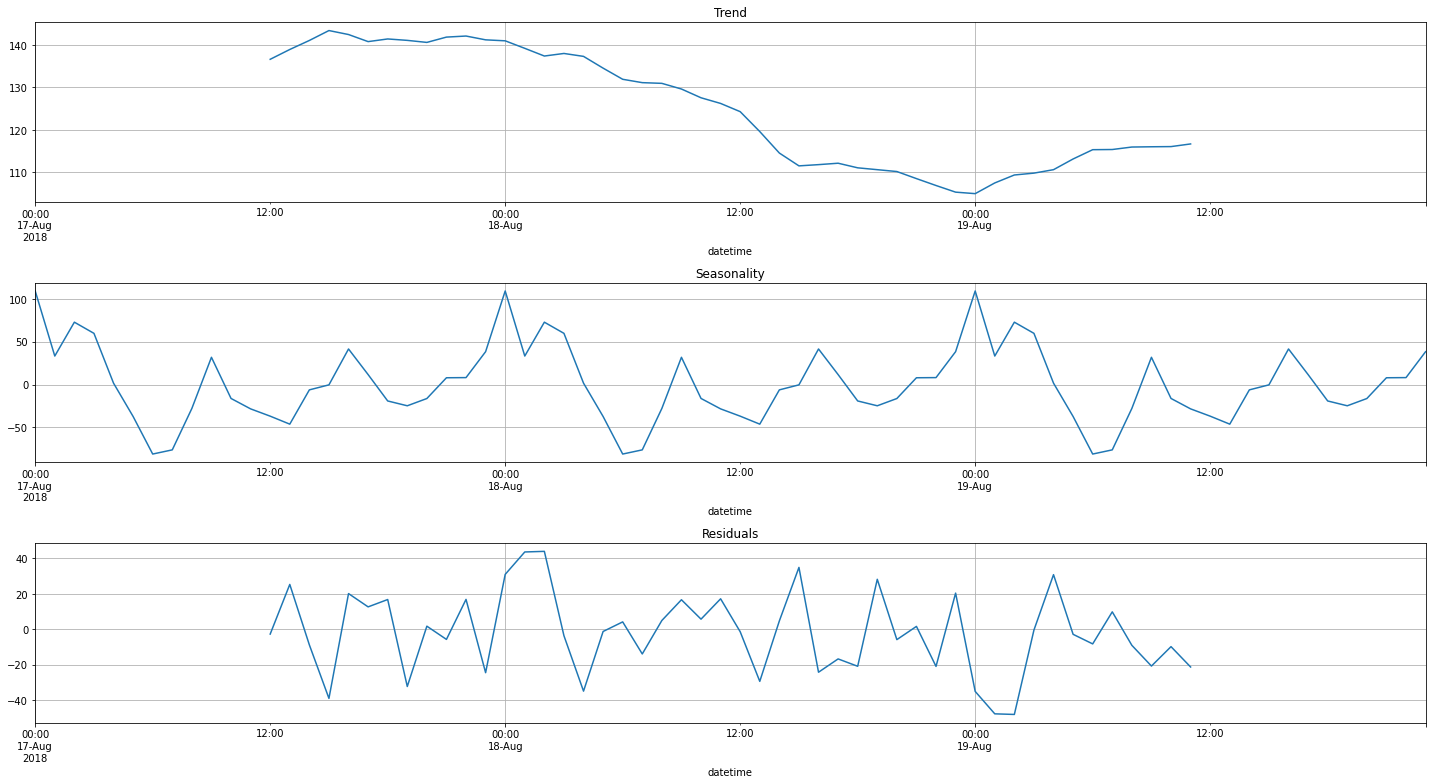

In [ ]:
#  тренды и сезонность

decomposed = seasonal_decompose(data_resampled_h['2018-08-17':'2018-08-19'])

plt.figure(figsize=(20, 11))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.grid()
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.grid()
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.grid()

Тренд на повышение в августе, сезонность с периодом в пару часов

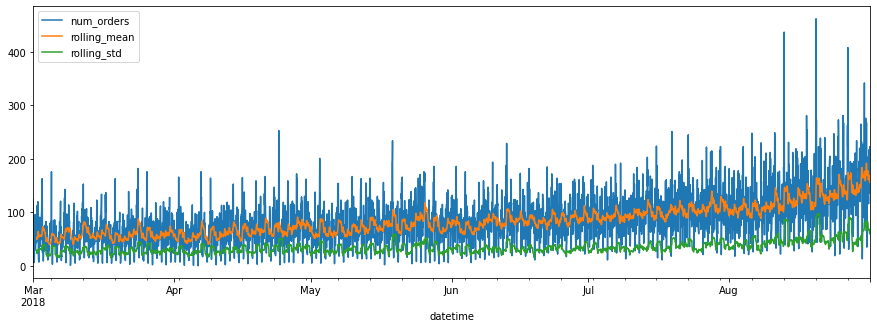

In [ ]:
# сглаживаем скользящим средним (размер окна = 20)
data_resampled_h['rolling_mean'] = data_resampled_h['num_orders'].rolling(20).mean()
data_resampled_h['rolling_std'] = data_resampled_h['num_orders'].rolling(20).std()
data_resampled_h.plot(figsize=(15,5));

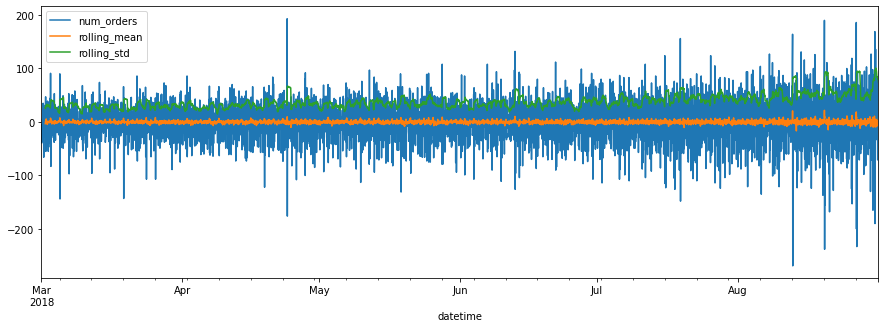

In [ ]:
# Чтобы ряд сделать стационарным, найдём разности его значений.
data_shifted_resampled = data_resampled_h - data_resampled_h.shift()
data_shifted_resampled['rolling_mean'] = data_shifted_resampled['num_orders'].rolling(20).mean()
data_shifted_resampled['rolling_std'] = data_shifted_resampled['num_orders'].rolling(20).std()
data_shifted_resampled.plot(figsize=(15,5));

# стандартное отклонение стало выше средних значений (тк появилось много отрицательных значений)

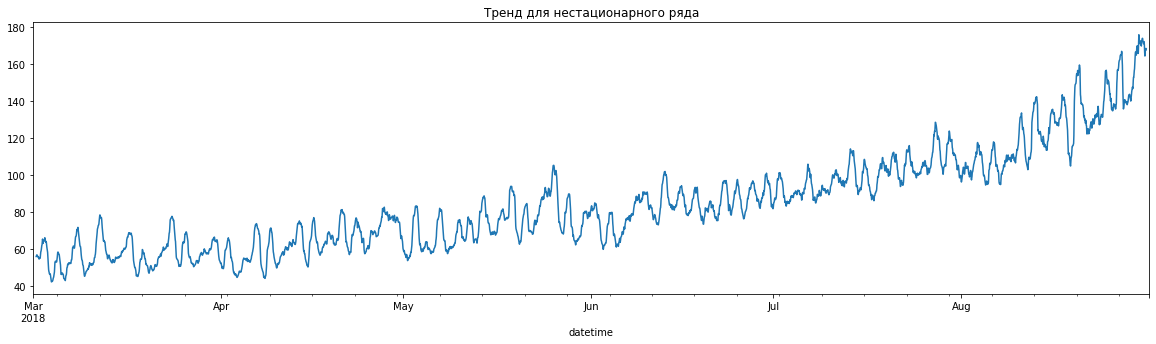

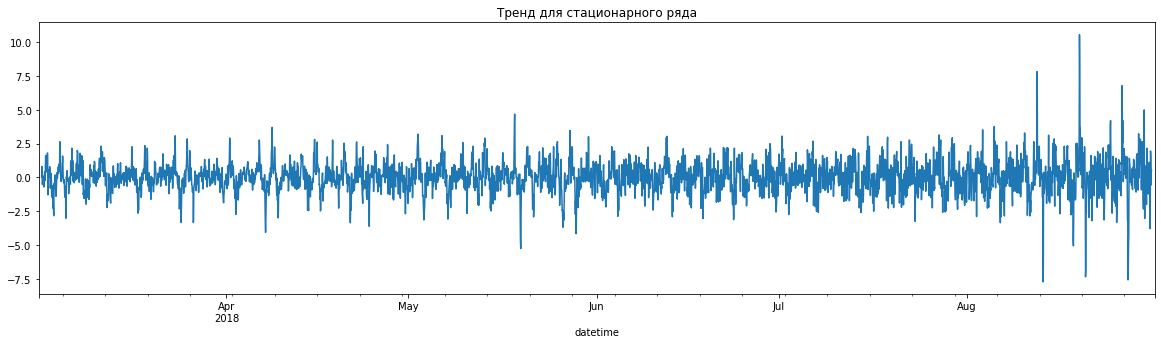

In [ ]:
#  Тренд для стационарного и нестационарного рядов
decomposed = seasonal_decompose(data_resampled_h['num_orders'])
decomposed_s = seasonal_decompose(data_shifted_resampled['num_orders'].dropna())

plt.figure(figsize=(20, 5));
decomposed.trend.plot();
plt.title('Тренд для нестационарного ряда');

plt.figure(figsize=(20, 5));
decomposed_s.trend.plot();
plt.title('Тренд для стационарного ряда');

In [ ]:
if adfuller(data_resampled_h['num_orders'])[1]>0.05:
    print('Ряд data_resampled_h[num_orders] нестационарный')
else:
    print('Ряд data_resampled_h[num_orders] стационарный')

Ряд data_resampled_h[num_orders] стационарный


**Вывод:**
Было произведено ресемплирование данных по 1 часу. Чтобы ряд сделать стационарным, были найдены разности его значений. Далее найдено скользящее среднее и стандартное отклонение.

Далее для обучения будут использованы ресемплированые данные без сдвига целевого признака, так как ряд является стационарным.

## Обучение

In [ ]:
train_0, test_0 = train_test_split(data_resampled_h, shuffle=False, test_size=0.1)

print('Период TRAIN c', train_0.index.min(), 'по', train_0.index.max())
print('Период TEST c', test_0.index.min(), 'по', test_0.index.max())


Период TRAIN c 2018-03-01 00:00:00 по 2018-08-13 13:00:00
Период TEST c 2018-08-13 14:00:00 по 2018-08-31 23:00:00


In [ ]:
# прогнозирование временных рядов без обучения
print("Среднее количество заказов за час:", test_0['num_orders'].mean())

pred_previous = test_0['num_orders'].shift().fillna(train_0['num_orders'].loc[train_0.index.max()])
print("MAE (средняя ошибка):", mean_absolute_error(test_0['num_orders'],pred_previous))
print('RMSE', (mean_squared_error(test_0['num_orders'],pred_previous))**0.5 )

Среднее количество заказов за час: 139.55656108597285
MAE (средняя ошибка): 44.97285067873303
RMSE 58.856486242815066


In [ ]:
# создадим новые признаки, которые не будут получены на истинном целевом признаке
def make_features(data, max_lag, rolling_mean_size):
  
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean_lag'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data_resampled_h, 2,24)
display(data_resampled_h.head())

,num_orders,rolling_mean,rolling_std,dayofweek,hour,lag_1,lag_2,rolling_mean_lag
datetime,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,NaN,NaN,3,4,66.0,71.0,NaN


Скользящее среднее в моменте t не учитывает текущее значение ряда x(t). Можно переходить к обучению.

In [ ]:
train, test = train_test_split(data_resampled_h, shuffle=False, test_size=0.1)

print('Период TRAIN c', train.index.min(), 'по', train.index.max())
print('Период TEST c', test.index.min(), 'по', test.index.max())


Период TRAIN c 2018-03-01 00:00:00 по 2018-08-13 13:00:00
Период TEST c 2018-08-13 14:00:00 по 2018-08-31 23:00:00


In [ ]:
train = train.dropna()
features_train = train.drop(['num_orders','rolling_mean','rolling_std'], axis=1)
features_test = test.drop(['num_orders','rolling_mean','rolling_std'], axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

In [ ]:
def rmse_scor (target, predictions):
    return (mean_squared_error(target,predictions))**0.5
    
rmse_score = make_scorer(rmse_scor, greater_is_better=False)

### LinearRegression

In [ ]:
model_linear = LinearRegression() 
tscv = TimeSeriesSplit(n_splits=24)
linear_cv = cross_val_score (model_linear,features_train,target_train, cv=tscv, scoring=rmse_score)
print('Среднее значение качества модели -', linear_cv.mean()*(-1))

Среднее значение качества модели - 30.627898890727092


### RandomForestRegressor

In [ ]:
%%time
# применение GridSearchCV
parametrs = {  'n_estimators': range(1, 16, 5),
             'max_depth': range(1, 6, 2),
              'min_samples_leaf': range(1,4),
              'min_samples_split': range(2,6,2),
            }
tscv = TimeSeriesSplit(n_splits=24)
model_rfr = RandomForestRegressor(random_state=12345)
grid = GridSearchCV(model_rfr, parametrs, cv= tscv, n_jobs=-1, scoring=rmse_score, verbose=1)
grid.fit(features_train,target_train)

Fitting 24 folds for each of 54 candidates, totalling 1296 fits
CPU times: user 1.6 s, sys: 187 ms, total: 1.78 s
Wall time: 27.8 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=24, test_size=None),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': range(1, 6, 2),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 6, 2),
                         'n_estimators': range(1, 16, 5)},
             scoring=make_scorer(rmse_scor, greater_is_better=False),
             verbose=1)

In [ ]:
print('Параметры наилучшей модели -', grid.best_params_) 
print('Наилучшее значение качества модели -', grid.best_score_*(-1))
print('Время предсказания -', grid.cv_results_['mean_score_time'][grid.cv_results_['rank_test_score'] == 1].min())

Параметры наилучшей модели - {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 11}
Наилучшее значение качества модели - 25.907044905595246
Время предсказания - 0.004447837670644124


### LGBMRegressor

In [ ]:
%%time

lgb_model = lgb.LGBMRegressor(random_state=12345)

lgb_parametrs = {"max_depth": [10, 50, 100],
               "num_leaves": [500, 1200],
               "n_estimators": range (5, 16, 5)
             }
#Применяю GridSearchCV
tscv = TimeSeriesSplit(n_splits=24)
lgb_grid = GridSearchCV(lgb_model, lgb_parametrs, scoring=rmse_score, cv=tscv, verbose=1)
lgb_grid.fit(features_train, target_train)

Fitting 24 folds for each of 18 candidates, totalling 432 fits
CPU times: user 24.8 s, sys: 2.08 s, total: 26.9 s
Wall time: 15 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=24, test_size=None),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'max_depth': [10, 50, 100],
                         'n_estimators': range(5, 16, 5),
                         'num_leaves': [500, 1200]},
             scoring=make_scorer(rmse_scor, greater_is_better=False),
             verbose=1)

In [ ]:
print('Параметры наилучшей модели -', lgb_grid.best_params_)
print('Наилучшее значение качества модели -', lgb_grid.best_score_*(-1))
print('Время предсказания -', lgb_grid.cv_results_['mean_score_time'][lgb_grid.cv_results_['rank_test_score'] == 1].min())

Параметры наилучшей модели - {'max_depth': 50, 'n_estimators': 15, 'num_leaves': 500}
Наилучшее значение качества модели - 24.572238541746845
Время предсказания - 0.002085655927658081


### CatBoostRegressor

In [ ]:
%%time

cb_model = cb.CatBoostRegressor(random_state=12345)

cb_parametrs = {'iterations': [200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8]
         }
tscv = TimeSeriesSplit(n_splits=24)
cb_grid = GridSearchCV(cb_model, cb_parametrs, scoring=rmse_score, cv=tscv, verbose=1)
cb_grid.fit(features_train, target_train, verbose = False)

Fitting 24 folds for each of 8 candidates, totalling 192 fits
CPU times: user 1min 22s, sys: 15.3 s, total: 1min 37s
Wall time: 1min 17s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=24, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f739cc9de20>,
             param_grid={'depth': [2, 4, 6, 8], 'iterations': [200],
                         'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(rmse_scor, greater_is_better=False),
             verbose=1)

In [ ]:
print('Параметры наилучшей модели -', cb_grid.best_params_)
print('Наилучшее значение качества модели -', cb_grid.best_score_*(-1))
print('Время предсказания -', cb_grid.cv_results_['mean_score_time'][cb_grid.cv_results_['rank_test_score'] == 1].min())

Параметры наилучшей модели - {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Наилучшее значение качества модели - 22.982938294425335
Время предсказания - 0.0030940075715382895


In [ ]:
# сбор полученных данных
report = pd.DataFrame(columns = ["LinearRegression","RandomForest","LightGBM", "CatBoost"],
                      index = ["RMSE(train) or CV.mean()"])


report.iloc[0] = [(linear_cv.mean()*(-1)), (grid.best_score_*(-1)), (lgb_grid.best_score_*(-1)), (cb_grid.best_score_*(-1))]
report

,LinearRegression,RandomForest,LightGBM,CatBoost
RMSE(train) or CV.mean(),30.627899,25.907045,24.572239,22.982938


**Вывод:**

Наилучшее значение качества на обучающей выборке у модели CatBoostRegressor 22.98 - с параметрами {depth': 8, 'iterations': 200, 'learning_rate': 0.1}

## Тестирование

In [ ]:
%%time
cb_model = cb.CatBoostRegressor(random_state=12345, depth= 8, iterations = 200, learning_rate = 0.1)
cb_model.fit(features_train, target_train,verbose = False)
prediction_cb = cb_model.predict(features_test)


CPU times: user 1.22 s, sys: 505 ms, total: 1.72 s
Wall time: 1.96 s


In [ ]:
print('RMSE = ', (mean_squared_error(target_test, prediction_cb))**0.5)
print('Время выполнения -', 1.85, "сек")

RMSE =  46.979655513549
Время выполнения - 1.85 сек


**Вывод:**

При применении модели CatBoostRegressor с наилучшими параметрами на тестовой выборке значение качества RMSE = 46.98 (удовлетворяет задание (RMSE<=48), модель подходит). Время выполнения предсказания - 1.85 сек

In [ ]:
# визуализация предсказанных и целевых значений
prediction_cb_2= pd.DataFrame(prediction_cb, index = features_test.index)
prediction_cb_2=prediction_cb_2.rename(columns={0:'predicted_values'})
total_table = target_test.copy().to_frame()
total_table=total_table.join(prediction_cb_2, on=total_table.index)
total_table.head()

,num_orders,predicted_values
datetime,,
2018-08-13 14:00:00,102,101.341105
2018-08-13 15:00:00,175,111.183068
2018-08-13 16:00:00,144,137.620773
2018-08-13 17:00:00,152,114.338535
2018-08-13 18:00:00,104,95.351716


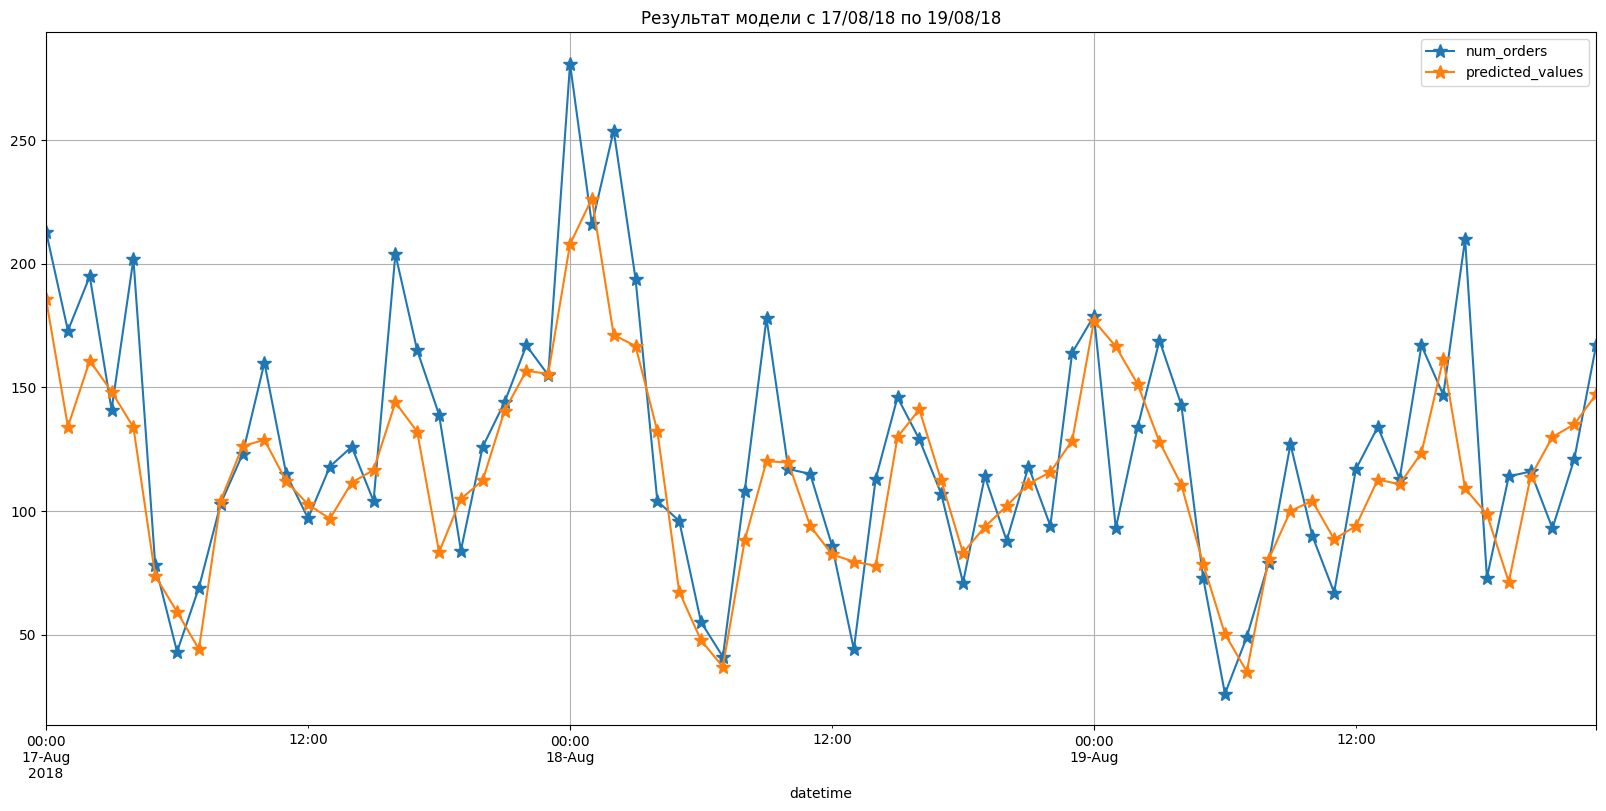

In [ ]:
total_table['2018-08-17':'2018-08-19'].plot(grid=True, figsize=(20,9), marker='*',ms = 10,title='Результат модели с 17/08/18 по 19/08/18');

Модель плохо предсказала пиковые значения, занизив их